# Import Library

In [1]:
# Data Loading
import xarray as xr  

# Data Processing
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon

# Data Load

In [2]:
path = './precip.mon.ltm.nc'

ncfile = xr.open_dataset(path)
print(ncfile) # print dataset infomation 

<xarray.Dataset>
Dimensions:             (lat: 72, lon: 144, nbnds: 2, time: 12)
Coordinates:
  * lat                 (lat) float32 88.75 86.25 83.75 ... -83.75 -86.25 -88.75
  * lon                 (lon) float32 1.25 3.75 6.25 ... 353.75 356.25 358.75
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] ...
    precip              (time, lat, lon) float32 ...
    valid_yr_count      (time, lat, lon) float32 ...
Attributes:
    Conventions:                    COARDS
    title:                          CPC Merged Analysis of Precipitation (exc...
    platform:                       Analyses
    source:                         ftp ftp.cpc.ncep.noaa.gov precip/cmap/mon...
    dataset_title:                  CPC Merged Analysis of Precipitation
    documentation:                  https://www.esrl.noaa.gov/psd/data/gridde...
    date_modified:              

/usr/local/python/2.7/envs/p3.6_cpu/lib/python3.6/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/python/2.7/envs/p3.6_cpu/lib/python3.6/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


# Data Processing

In [3]:
# select variable
precip = ncfile.data_vars['precip']
print(precip.shape)  # [time, lat, lon]

(12, 72, 144)


In [4]:
# check null values
np.sum(np.isnan(precip))

<xarray.DataArray 'precip' ()>
array(5905)

In [5]:
# print time information
precip.time

<xarray.DataArray 'time' (time: 12)>
array([cftime.DatetimeGregorian(1, 1, 1, 0, 0, 0, 0, 5, 1),
       cftime.DatetimeGregorian(1, 2, 1, 0, 0, 0, 0, 1, 32),
       cftime.DatetimeGregorian(1, 3, 1, 0, 0, 0, 0, 1, 60),
       cftime.DatetimeGregorian(1, 4, 1, 0, 0, 0, 0, 4, 91),
       cftime.DatetimeGregorian(1, 5, 1, 0, 0, 0, 0, 6, 121),
       cftime.DatetimeGregorian(1, 6, 1, 0, 0, 0, 0, 2, 152),
       cftime.DatetimeGregorian(1, 7, 1, 0, 0, 0, 0, 4, 182),
       cftime.DatetimeGregorian(1, 8, 1, 0, 0, 0, 0, 0, 213),
       cftime.DatetimeGregorian(1, 9, 1, 0, 0, 0, 0, 3, 244),
       cftime.DatetimeGregorian(1, 10, 1, 0, 0, 0, 0, 5, 274),
       cftime.DatetimeGregorian(1, 11, 1, 0, 0, 0, 0, 1, 305),
       cftime.DatetimeGregorian(1, 12, 1, 0, 0, 0, 0, 3, 335)], dtype=object)
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Attributes:
    long_name:                 Time
    delta_t:                   0000-01-00 00:00:00
    avg_period:        

In [6]:
# select USA domain
precip_usa = precip.sel(lon=slice(225,295),lat=slice(60,20)) # pick slightly larger for visualization

# calculate RMS
rms = precip_usa.std(dim='time')
#season_dif = precip_usa.sel(time='0001-07')[0] - precip_usa.sel(time='0001-01')[0]

# area average
region1 = precip.sel(lon=slice(233,240),lat=slice(50,44)).mean(dim=['lon', 'lat'])
region2 = precip.sel(lon=slice(262,267),lat=slice(43,38)).mean(dim=['lon', 'lat'])

# Visualizatoin

In [7]:
# customized function for boounding box
def draw_box(ax, m, lon1, lon2, lat1, lat2, idx):
    x1, y1 = m(lon1, lat1)
    x2, y2 = m(lon1, lat2)
    x3, y3 = m(lon2, lat2)
    x4, y4 = m(lon2, lat1)
    poly = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4)], facecolor='none', edgecolor='k', linewidth=2.)
    ax.add_patch(poly)
    ax.annotate(s=idx, xy=m((lon1+lon2)/2, (lat1+lat2)/2), fontsize=20, fontweight='bold',
                horizontalalignment='center', verticalalignment='center')

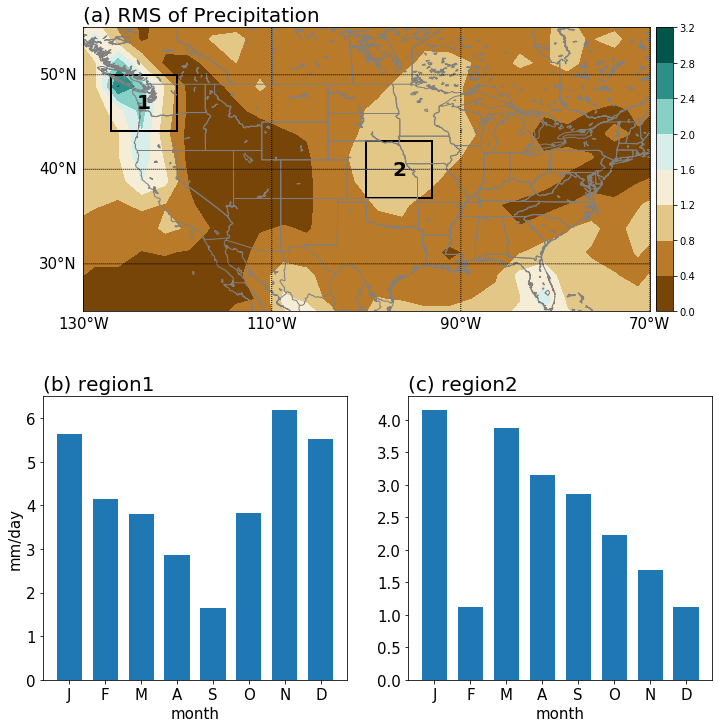

In [8]:
# set multiple figures 
fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=2, nrows=2)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

top_ax = fig.add_subplot(spec[0,:])
bottom_left_ax = fig.add_subplot(spec[1,0])
bottom_right_ax = fig.add_subplot(spec[1,1])


### 1. top plot
m = Basemap(
    lon_0=0, lat_0=0, # center of mat domain
    llcrnrlon=230., llcrnrlat=25., urcrnrlon=290., urcrnrlat=55., # projection region
    resolution='i', # boundary resolution (c, l, i, h, f)
    ax=top_ax,
)

coord = np.meshgrid(rms.lon, rms.lat)

m.drawcoastlines(linewidth=1., color='gray') # draw coastline
m.drawcountries(linewidth=1., color='gray') # draw country line
m.drawstates(linewidth=1., color='gray') # draw state line
m.drawparallels(np.linspace(30,50,3), labels=[1,0,0,0], fontsize=15) # draw horizontal grid line
m.drawmeridians(np.linspace(230,290,4), labels=[0,0,0,1], fontsize=15) # draw vertical grid line


plot1 = m.contourf(coord[0], coord[1], rms,
          cmap=plt.cm.BrBG,
          )
draw_box(top_ax, m, 233,240,50,44, '1')
draw_box(top_ax, m, 260,267,37,43, '2')


cbar = m.colorbar(plot1, ax=top_ax,
                 location='right',
                 pad='1%', size='3%') # colorbar
cbar.ax.tick_params(labelsize=10)

top_ax.set_title('(a) RMS of Precipitation', 
                 loc='left', fontsize=20) # plot title

### 2. bottom plots
month = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

bottom_left_ax.bar(month, region1, width=0.7)
bottom_left_ax.set_title('(b) region1', 
                 loc='left', fontsize=20)
bottom_left_ax.set_ylabel('mm/day', fontsize=15)
bottom_left_ax.set_xlabel('month', fontsize=15)
bottom_left_ax.tick_params(labelsize=15)

bottom_right_ax.bar(month, region2, width=0.7)
bottom_right_ax.set_title('(c) region2', 
                 loc='left', fontsize=20)
bottom_right_ax.set_xlabel('month', fontsize=15)
bottom_right_ax.tick_params(labelsize=15)